In [98]:
import matplotlib.pylab as plt
import pandas as pd
import seaborn as sns
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import DBSCAN
from sklearn.svm import SVC
import numpy as np
import hdbscan
import os.path
from seaborn import scatterplot

from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

## Preparation

In [99]:
import pandas as pd
import os.path
FILEID = 1
FILEIDS = [1, 3, 36, 39, 49, 52]
LOGFILE = f"https://mcfp.felk.cvut.cz/publicDatasets/IoTDatasets/CTU-IoT-Malware-Capture-{FILEID}-1/bro/conn.log.labeled"
NUMERIC_COLUMNS = ['ts', 'orig_p', 'resp_p', "orig_bytes", "resp_bytes", "missed_bytes", "orig_pkts", 'orig_ip_bytes', 'resp_pkts', 'resp_ip_bytes', 'duration'] # integer columns

In [100]:
def convert_to_csv(FILEID):
    if not os.path.isfile(f'csv/capture{FILEID}_1.csv'):
        LOGFILE = f"https://mcfp.felk.cvut.cz/publicDatasets/IoTDatasets/CTU-IoT-Malware-Capture-{FILEID}-1/bro/conn.log.labeled"
        fieldsIN = ['ts', 'uid', 'orig_h', 'orig_p', 'resp_h', 'resp_p', 'proto', 'service', 'duration', 'orig_bytes', 'resp_bytes', 'conn_state',
                'local_orig', 'local_resp', 'missed_bytes', 'history', 'orig_pkts', 'orig_ip_bytes', 'resp_pkts', 'resp_ip_bytes', 'tunnel_parents', 'label', 'detailed_label']
        df = pd.read_csv(LOGFILE, sep="\x09|\x20\x20\x20", skiprows=10, skipfooter=2,
                        names=fieldsIN, header=None, engine='python')
                                
        df = df.drop(['tunnel_parents'], axis=1)
        df.to_csv(f'csv/capture{FILEID}_1.csv')
        print(df.shape)
        for column in NUMERIC_COLUMNS:
            df[column] = pd.to_numeric(df[column], errors='coerce')
        return df


In [101]:
def norm_df(df, rows=None):
    df = df.dropna()
    df = df.replace('-', np.NAN)
    df = df.drop(['Unnamed: 0','service', 'duration', 'missed_bytes', 'history', 'uid', 'conn_state', 'local_orig', 'local_resp', 'orig_ip_bytes', 'resp_ip_bytes', 'orig_pkts', 'resp_pkts', 'detailed_label'], axis=1)
    string_cols = ['orig_h', 'resp_h', 'proto']
    df[string_cols] = df[string_cols].astype(str)
    if (rows): return df[:rows]
    else: return df

In [102]:
SOURCEDF = norm_df(pd.read_csv('csv/capture1_1.csv'), 300)
print(SOURCEDF.shape)
print(SOURCEDF.dtypes)
SOURCEDF.head()


(300, 9)
ts            float64
orig_h         object
orig_p          int64
resp_h         object
resp_p          int64
proto          object
orig_bytes     object
resp_bytes     object
label          object
dtype: object


,ts,orig_h,orig_p,resp_h,resp_p,proto,orig_bytes,resp_bytes,label
0,1.525880e+09,192.168.100.103,41101,111.40.23.49,23,tcp,NaN,NaN,Malicious
1,1.525880e+09,192.168.100.103,60905,131.174.215.147,23,tcp,0,0,Malicious
2,1.525880e+09,192.168.100.103,44301,91.42.47.63,23,tcp,NaN,NaN,Malicious
3,1.525880e+09,192.168.100.103,50244,120.210.108.200,23,tcp,NaN,NaN,Malicious
4,1.525880e+09,192.168.100.103,34243,147.7.65.203,49560,tcp,0,0,Benign


## Clustering

In [103]:
def hdbscanner(df):
    hdbscan_obj = hdbscan.HDBSCAN(algorithm='best', alpha=1.0, approx_min_span_tree=True,
    gen_min_span_tree=False, leaf_size=40, metric='euclidean', min_cluster_size=5, min_samples=None, p=None).fit(df)
    labels = hdbscan_obj.labels_
    df['category'] = pd.Series(labels)
    return df


In [104]:
# takes 3m52.2s
ROWS = 1000
df1_ = SOURCEDF.loc[:ROWS, ['orig_bytes','resp_bytes','orig_p', 'resp_p']]
df1 = hdbscanner(df1_)

In [105]:
df1.head(10)


,orig_bytes,resp_bytes,orig_p,resp_p,category
0,NaN,NaN,41101,23,-1
1,0,0,60905,23,1
2,NaN,NaN,44301,23,-1
3,NaN,NaN,50244,23,-1
4,0,0,34243,49560,-1
5,NaN,NaN,34840,21288,-1
6,NaN,NaN,58525,23,-1
7,NaN,NaN,43849,8080,-1
8,NaN,NaN,40973,8080,-1
9,0,0,52259,23,1


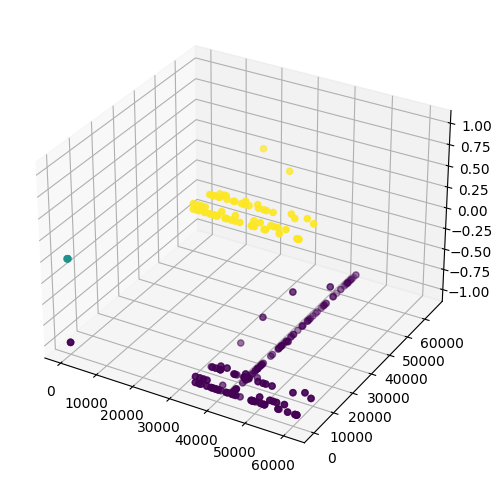

In [106]:
fig = plt.figure(figsize=(6,6))

ax = plt.axes(projection='3d')
#sc = ax.scatter(data=df1, x='orig_p', y='resp_p', z='category', s=40, c='category', marker='o', cmap='plasma', alpha=1)

ax.scatter3D(df1['orig_p'], df1['resp_p'], df1['category'], c=df1['category'])

plt.show()

## Model Training using linear Kernel
from [here](https://datagy.io/python-support-vector-machines/)

In [107]:
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score


In [108]:

X = df1[['orig_p', 'resp_p']]
y = df1['category']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=100)


In [109]:
def train_linear():
    # Building and training our model
    clf = SVC(kernel='linear', verbose=False)
    clf.fit(X_train, y_train)
    predictions = clf.predict(X_test)
    print(f"Acccuracy: {accuracy_score(y_test, predictions)}")
    # interrupted after 526 minutes
    return clf

In [110]:
def visualise_linear(clf):
# Visualizing the linear function for our SVM classifier
    w = clf.coef_[0]
    b = clf.intercept_[0]
    x_visual = np.linspace(0,60000)
    y_visual = -(w[0] / w[1]) * x_visual - b / w[1]

    scatterplot(data = X_train, x='orig_p', y='resp_p', hue=y_train)
    plt.plot(x_visual, y_visual)
    plt.show()

## Model Training using better Kernel
**THIS DID NOT WORK AS EXPECTED AND SINCE SVM IS NOT NECESSARY ANYWAYS, IT WONT BE FIXED**

In [111]:
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import make_column_transformer
from sklearn.model_selection import train_test_split
from sklearn.compose import make_column_transformer

In [112]:
def encoder(df: pd.DataFrame):
    X = df.drop(['label'], axis=1)
    y = df['label'].to_frame()
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 100)
    column_transformer = make_column_transformer(
    (OneHotEncoder(), ['orig_h', 'resp_h', 'proto']),
    remainder='passthrough')
    X_train = column_transformer.fit_transform(X_train)
    X_train = pd.DataFrame(data=X_train, columns=column_transformer.get_feature_names_out())
    print(X_train.head())

# encoder(SOURCEDF)

## Training using ANN
link :[here](https://www.analyticsvidhya.com/blog/2021/10/implementing-artificial-neural-networkclassification-in-python-from-scratch/)

In [113]:
import tensorflow as tf

2023-06-14 12:20:10.581837: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-06-14 12:20:10.626941: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-06-14 12:20:10.627587: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-14 12:20:12.622510: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [117]:
def ann_encoder(df):
    enc = make_column_transformer((OneHotEncoder(), ['orig_h', 'resp_h', 'proto']), remainder='passthrough')
    transformed = enc.fit_transform(df)
    transformed_df = pd.DataFrame(transformed, columns=enc.get_feature_names())
    print(transformed_df.head())
    df = pd.get_dummies(df, columns=['orig_h', 'resp_h', 'proto'])
    print(enc)
    return df

ann_encoder(SOURCEDF)

ValueError: For a sparse output, all columns should be a numeric or convertible to a numeric.